In [1]:
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# 1D function 

In [2]:
# define objective function 
def objective(x):
    loss = (x - 2) ** 2
    return {'loss': loss, 'status': STATUS_OK}

# define search space 
space = hp.uniform('x', -10, 10)

trials = Trials()
# minimize the objective function 
sol = fmin(
    objective, space, algo=tpe.suggest, 
    trials=trials, max_evals=100
)

print('')
print(sol)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 570.46trial/s, best loss: 1.5265428004242257e-05]

{'x': 1.99609290030787}


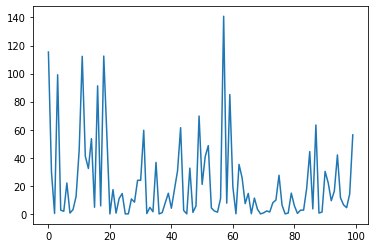

In [3]:
plt.plot(trials.losses())

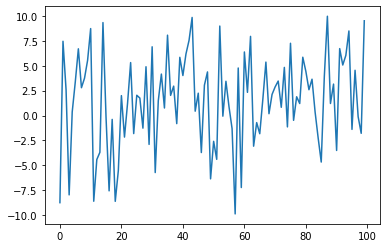

In [4]:
plt.plot(trials.idxs_vals[1]['x'])

# 2D function 

In [5]:
# define objective function 
def objective(space):
    x = space['x']
    y = space['y']
    return x ** 2 + y ** 2

# define search space 
space = {
    'x': hp.uniform('x', -1, 1), 
    'y': hp.uniform('y', -1, 1), 
}

# minimize the objective funtion 
sol = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print(sol)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.69trial/s, best loss: 0.00033124708199541773]
{'x': -0.014353491255006331, 'y': -0.011190369555464846}


# Functional 

In [6]:
def objective(space):
    x = space['x']
    return x ** 2 + func(**space['func_space'])

def func(y):
    return y ** 2 

space = {
    'x': hp.uniform('x', -1, 1), 
    'func_space': {
        'y': hp.uniform('y', -1, 1)
    }
}

# minimize the objective funtion 
sol = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print(sol)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.67trial/s, best loss: 0.0016906226194066563]
{'x': 0.037527827777891896, 'y': -0.016801332140028116}


In [7]:
sol

{'x': 0.037527827777891896, 'y': -0.016801332140028116}

# Args and Kwargs 

In [8]:
def my_sum_arg(*args):
    result = 0 
    for x in args:
        result += x 
    
    return result 

print(my_sum_arg(1, 2, 3, 4))
print(my_sum_arg(*[1, 2, 3, 4]))

10
10


In [9]:
def my_sum_kwarg(**kwargs):
    result = 0 
    for arg in kwargs.values():
        result += arg
    return result 

print(my_sum_kwarg(x=1, y=2, z=3))
print(my_sum_kwarg(**{'x':1, 'y':2, 'z':3}))

6
6


# RandomForest 

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [11]:
def load_data():
    X, y = make_classification(
        n_samples=10000, 
        n_features=5,
        n_informative=5,
        n_redundant=0,
        random_state=77
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=77
    )
    return X_train, X_test, y_train, y_test 

# generate data 
X_train, X_test, y_train, y_test = load_data()

In [12]:
# params goes in `Model()` class 
params = {
    # fixed parameters 
    'n_estimators': 20, 
    'criterion': 'entropy', 
    
    # tune parameters 
    'max_depth': hp.quniform('max_depth', 2, 100, 1), 
    'min_samples_split': hp.uniform('min_sample_split', 0, 1)
}

In [13]:
def objective(params):
    model = RandomForestClassifier(**params)
    model.fit(
        X_train, y_train, 
    ) 
    loss = roc_auc_score( 
        y_test, model.predict(X_test)
    )
    return {'loss': loss, 'status': STATUS_OK}

In [14]:
trials = Trials()

best = fmin(
    fn=objective, 
    space=params, 
    algo=tpe.suggest, 
    max_evals=100,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.68trial/s, best loss: 0.5]


In [15]:
best 

{'max_depth': 82.0, 'min_sample_split': 0.7544961586352608}

# LGBM 

In [16]:
import numpy as np
from lightgbm import LGBMClassifier
from hyperopt.pyll.base import scope

In [17]:
tune_params = {
    'learning_rate': hp.loguniform('learning_rate', -3, 3),
    'reg_alpha': hp.choice('reg_alpha', [0, hp.loguniform('reg_alpha_float', -7.0, 7.0)]),
    'reg_lambda': hp.choice('reg_lambda', [0, 1, hp.loguniform('reg_lambda_float', -7.0, 7.0)]),
    'subsample': hp.choice('subsample', [1.0, hp.uniform('subsample_uniform', 0.5, 1.0)]),
    'colsample_bytree': hp.choice('colsample_bytree', [1.0, hp.uniform('colsample_bytree_uniform', 0.5, 1.0)]),
    'min_child_samples': hp.choice(
        'min_child_samples', [
            0, scope.int(hp.qloguniform('min_child_samples_float', 0.0, 7.0, 1)) # int socpe is added 
        ]
    ),    
}

fixed_params = { 
    'max_depth': 5,
    'num_leaves': 15,  
    'n_estimators': 150, 
    'random_state': 479092, 
    'verbose': -1, 
    'n_jobs': -1,
}

model_params = {**tune_params, **fixed_params}

fit_params = {
#     'early_stopping_rounds': 10, 
#     'eval_metric': 'roc-auc'
}

params = dict()
params['model_params'] = model_params 
params['fit_params'] = fit_params 

params['loss_func'] = lambda y, y_pred: roc_auc_score(y, y_pred)

In [18]:
def objective(params):
    model = LGBMClassifier(**params['model_params'])
    model.fit(X_train, y_train, **params['fit_params'])
    loss = params['loss_func'](
        y_test, model.predict(X_test)
    )
    return loss 

In [19]:
best = fmin(
    fn=objective, 
    space=params, 
    algo=tpe.suggest, 
    max_evals=10,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.13trial/s, best loss: 0.6665037565348088]


In [20]:
best 

{'colsample_bytree': 1,
 'colsample_bytree_uniform': 0.7260700232538574,
 'learning_rate': 5.47219210066627,
 'min_child_samples': 0,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 1,
 'subsample_uniform': 0.5898172359568523}

# Custom Loss function 

In [21]:
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

from scipy import special
import lightgbm as lgbm
from custom_loss import LogLoss, FocalLoss

In [22]:
def objective(params): 
    #cusom loss function 
    lgbm_loss = LogLoss()
    
    # prepare train data 
    train = lgbm.Dataset(
        X_train, y_train,
        init_score=np.full_like(
            y_train, 
            lgbm_loss.init_score(y_train),
            dtype=float  
        )
    )
    
    # prepare the model 
    model = lgbm.train(
        params=params['model_params'], 
        train_set=train,
        fobj=lgbm_loss.lgb_obj, 
        feval=lgbm_loss.lgb_eval,
    )
    
    # pred and loss 
    y_pred_test = special.expit(
        lgbm_loss.init_score(y_train) + \
        model.predict(X_test) #lgbm loaa is here too 
    )
    loss = roc_auc_score(
        y_test, y_pred_test
    )
    return loss

In [23]:
best = fmin(
    fn=objective, 
    space=params, 
    algo=tpe.suggest, 
    max_evals=10,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.56trial/s, best loss: 0.6039219414022818]


In [24]:
best

{'colsample_bytree': 1,
 'colsample_bytree_uniform': 0.5894368073117708,
 'learning_rate': 4.252461329704456,
 'min_child_samples': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0}

# Tuning custom loss parameter 

In [25]:
# focal loss hyperparameters 
loss_params = {
    'alpha': hp.uniform('alpha', 0.5, 1), 
    'gamma': hp.uniform('gamma', -5, 5), 
}
params['loss_params'] = loss_params

In [26]:
def objective(params): 
    '''
    this objective function is specific to a loss function. 
    objective can only have params as an argument. 
    '''
    #cusom loss function 
    lgbm_loss = FocalLoss(**params['loss_params'])
    
    # prepare train data 
    train = lgbm.Dataset(
        X_train, y_train,
        init_score=np.full_like(
            y_train, 
            lgbm_loss.init_score(y_train),
            dtype=float  
        )
    )
    
    # prepare the model 
    model = lgbm.train(
        params=params['model_params'], 
        train_set=train,
        fobj=lgbm_loss.lgb_obj, 
        feval=lgbm_loss.lgb_eval,
    )
    
    # pred and loss 
    y_pred_test = special.expit(
        lgbm_loss.init_score(y_train) + \
        model.predict(X_test) 
    )
    loss = roc_auc_score(
        y_test, y_pred_test
    )
    return loss

In [27]:
best = fmin(
    fn=objective, 
    space=params, 
    algo=tpe.suggest, 
    max_evals=10,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14trial/s, best loss: 0.0236523747432325]


In [28]:
best

{'alpha': 0.9696838350659636,
 'colsample_bytree': 1,
 'colsample_bytree_uniform': 0.754895918177626,
 'gamma': -4.326630986530915,
 'learning_rate': 0.09730777966197232,
 'min_child_samples': 0,
 'reg_alpha': 0,
 'reg_lambda': 2,
 'reg_lambda_float': 0.8808901180142801,
 'subsample': 0}

# `HyperOpt()` class 

In [29]:
class HyperOpt(object):

    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.X_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

    def optimize(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        return result, trials

    def objective(self, para):
        model = LGBMClassifier(**para['model_params'])
        model.fit(self.X_train, self.y_train,
                **para['fit_params'])
        pred = model.predict(self.X_test)
        loss = roc_auc_score(self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [30]:
obj = HyperOpt(X_train, y_train, X_test, y_test)

trials = Trials()

best = obj.optimize(
    fn_name='objective', 
    space=params, 
    trials=trials, 
    algo=tpe.suggest, 
    max_evals=10
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.68trial/s, best loss: 0.49117372749263705]


In [31]:
best

({'alpha': 0.8439635696789682,
  'colsample_bytree': 1,
  'colsample_bytree_uniform': 0.5373195706690053,
  'gamma': -1.3949267457974046,
  'learning_rate': 2.9886967194258,
  'min_child_samples': 0,
  'reg_alpha': 1,
  'reg_alpha_float': 28.232127060481126,
  'reg_lambda': 0,
  'subsample': 0},
 <hyperopt.base.Trials at 0x7f321255cf40>)